In [327]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<AxesSubplot:>

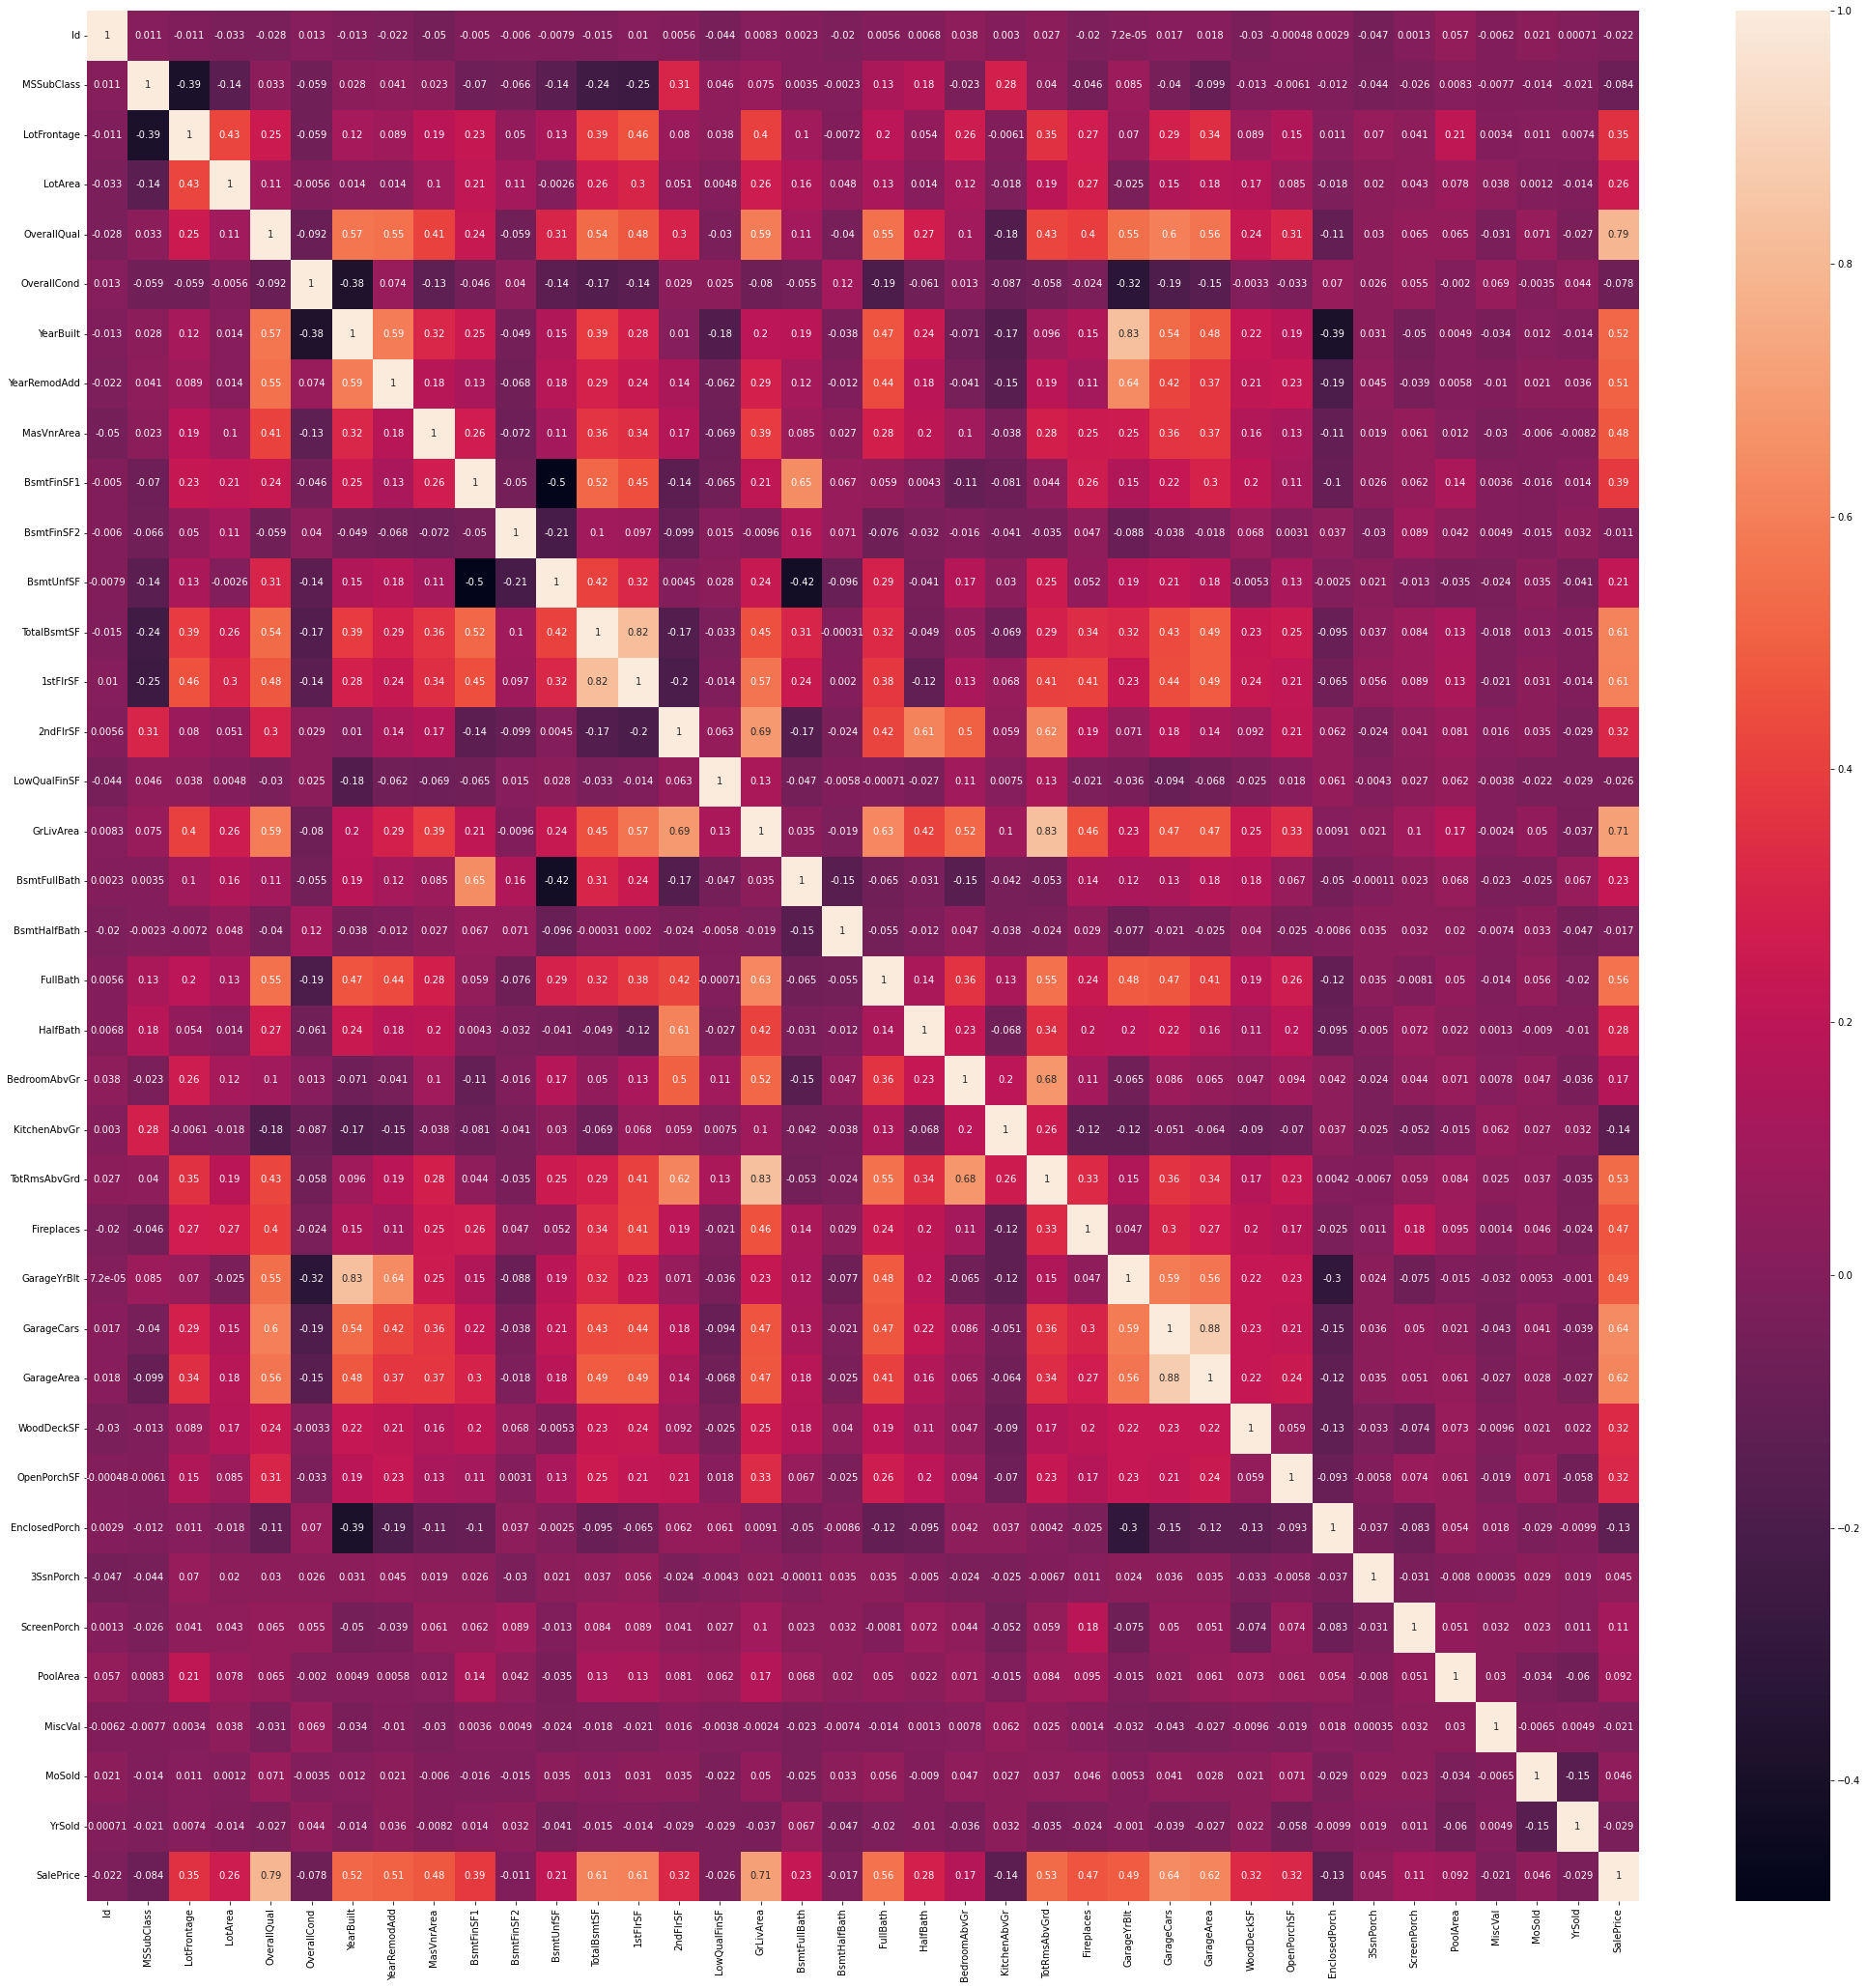

In [335]:
X = pd.read_csv("data/train.csv")
X_test = pd.read_csv("data/test.csv")

fig, ax = plt.subplots(figsize=(36, 36))
df_corr = X.corr()

sns.heatmap(df_corr,annot=True)
      

In [329]:
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)




In [336]:

def prep_missing(dfin):
    dfin.drop(['MiscFeature'], axis=1, inplace=True)
    dfin.drop(['PoolQC'], axis=1, inplace=True)
    dfin.drop(['Alley'], axis=1, inplace=True)
    dfin.drop(['FireplaceQu'], axis=1, inplace=True) 
    dfin.drop(['Fence'], axis=1, inplace=True)  
    dfin.drop(['GarageType'], axis=1, inplace=True)        
    dfin.drop(['GarageYrBlt'], axis=1, inplace=True)        
    dfin.drop(['GarageFinish'], axis=1, inplace=True)     
    dfin.drop(['GarageQual'], axis=1, inplace=True)
    dfin.drop(['GarageCond'], axis=1, inplace=True)
    dfin.Electrical = dfin.Electrical.fillna('SBrkr')
    dfin.BsmtFinSF1 = dfin.BsmtFinSF1.fillna(0)
    dfin.BsmtFinSF2 = dfin.BsmtFinSF2.fillna(0)
    dfin.GarageCars = dfin.GarageCars.fillna(0)
    dfin.GarageArea = dfin.GarageArea.fillna(0)
    dfin.BsmtQual[(dfin.BsmtFinSF1 == 0)] = dfin.BsmtQual[(dfin.BsmtFinSF1 == 0)].fillna('NA')
    dfin.BsmtCond[(dfin.BsmtFinSF1 == 0)] = dfin.BsmtCond[(dfin.BsmtFinSF1 == 0)].fillna('NA')
    dfin.BsmtExposure[(dfin.BsmtFinSF1 == 0)] = dfin.BsmtExposure[(dfin.BsmtFinSF1 == 0)].fillna('NA')
    dfin.BsmtFinType1[(dfin.BsmtFinSF1 == 0)] = dfin.BsmtFinType1[(dfin.BsmtFinSF1 == 0)].fillna('NA')
    dfin.BsmtFinType2[(dfin.BsmtFinSF2 == 0)] = dfin.BsmtFinType2[(dfin.BsmtFinSF2 == 0)].fillna('NA')
    dfin.BsmtFinType2 = dfin.BsmtFinType2.fillna('Unf')
    dfin.LotFrontage = dfin.LotFrontage.fillna(X_train.LotFrontage.mean())
    dfin.MasVnrArea = dfin.MasVnrArea.fillna(0)
    dfin.MasVnrType = dfin.MasVnrType.fillna('None')

    
    #feature engineering for the Neighborhood
    dfin.loc[(dfin.Neighborhood == 'NridgHt') | (dfin.Neighborhood == 'NoRidge'), ['GoodNBH']] = 1
    dfin.GoodNBH = dfin.GoodNBH.fillna(0)
    dfin.drop(['Neighborhood'], axis=1, inplace=True)
    
    #Drop Categoricals that cannot be one hotted, and also not ordinally encoded
    dfin.drop(['Exterior1st'], axis=1, inplace=True)
    dfin.drop(['Exterior2nd'], axis=1, inplace=True)
    return dfin

X_train = prep_missing(X_train)
X_valid = prep_missing(X_valid)
X_test = prep_missing(X_test)



KeyError: "['MiscFeature'] not found in axis"

In [331]:
def prep_encoding(dfin,dfin_valid):
    
    # Get list of categorical variables
    s = (dfin.dtypes == 'object')
    object_cols = list(s[s].index)
    OrdinalCols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir','KitchenQual','Functional']
    NominalCols = [item for item in object_cols if item not in OrdinalCols]
    
    from sklearn.preprocessing import OrdinalEncoder
    ExterQual_enc = OrdinalEncoder(categories=[['Po','Fa','TA','Gd','Ex']])
    dfin[['ExterQual']] = ExterQual_enc.fit_transform(dfin[['ExterQual']])
    dfin[['ExterCond']] = ExterQual_enc.fit_transform(dfin[['ExterCond']])
    dfin[['HeatingQC']] = ExterQual_enc.fit_transform(dfin[['HeatingQC']])
    dfin[['KitchenQual']] = ExterQual_enc.fit_transform(dfin[['KitchenQual']])
    
    dfin_valid[['ExterQual']] = ExterQual_enc.transform(dfin_valid[['ExterQual']])
    dfin_valid[['ExterCond']] = ExterQual_enc.transform(dfin_valid[['ExterCond']])
    dfin_valid[['HeatingQC']] = ExterQual_enc.transform(dfin_valid[['HeatingQC']])

    dfin_valid[['KitchenQual']] = ExterQual_enc.transform(dfin_valid[['KitchenQual']])

    BsmtQual_enc = OrdinalEncoder(categories=[['NA','Po','Fa','TA','Gd','Ex']])
    dfin[['BsmtQual']] = BsmtQual_enc.fit_transform(dfin[['BsmtQual']])
    dfin[['BsmtCond']] = BsmtQual_enc.fit_transform(dfin[['BsmtCond']])
    
    dfin_valid[['BsmtQual']] = BsmtQual_enc.transform(dfin_valid[['BsmtQual']])
    dfin_valid[['BsmtCond']] = BsmtQual_enc.transform(dfin_valid[['BsmtCond']])    

    BsmtExposure_enc = OrdinalEncoder(categories=[['NA','No','Mn','Av','Gd']])
    dfin[['BsmtExposure']] = BsmtExposure_enc.fit_transform(dfin[['BsmtExposure']])
    
    dfin_valid[['BsmtExposure']] = BsmtExposure_enc.transform(dfin_valid[['BsmtExposure']])

    BsmtFinType1_enc = OrdinalEncoder(categories=[['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']])
    dfin[['BsmtFinType1']] = BsmtFinType1_enc.fit_transform(dfin[['BsmtFinType1']])
    dfin[['BsmtFinType2']] = BsmtFinType1_enc.fit_transform(dfin[['BsmtFinType2']])
    
    dfin_valid[['BsmtFinType1']] = BsmtFinType1_enc.transform(dfin_valid[['BsmtFinType1']])
    dfin_valid[['BsmtFinType2']] = BsmtFinType1_enc.transform(dfin_valid[['BsmtFinType2']])

    CentralAir_enc = OrdinalEncoder(categories=[['N','Y']])
    dfin[['CentralAir']] = CentralAir_enc.fit_transform(dfin[['CentralAir']])
    
    dfin_valid[['CentralAir']] = CentralAir_enc.transform(dfin_valid[['CentralAir']])    

    Functional_enc = OrdinalEncoder(categories=[['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']])
    dfin[['Functional']] = Functional_enc.fit_transform(dfin[['Functional']])
    
    dfin_valid[['Functional']] = Functional_enc.transform(dfin_valid[['Functional']])

    from sklearn.preprocessing import OneHotEncoder
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_X_train_cols = pd.DataFrame(OH_encoder.fit_transform(dfin[NominalCols]))

    OH_X_valid_cols = pd.DataFrame(OH_encoder.transform(dfin_valid[NominalCols]))

    OH_X_train_cols.index = dfin.index
    OH_X_valid_cols.index = dfin_valid.index
    num_OH_X_train = dfin.drop(NominalCols, axis=1)
    num_OH_X_valid = dfin_valid.drop(NominalCols, axis=1)    
    OH_X_train = pd.concat([num_OH_X_train,OH_X_train_cols], axis=1)
    OH_X_valid = pd.concat([num_OH_X_valid,OH_X_valid_cols], axis=1)    

    return OH_X_train, OH_X_valid

#X_train, X_valid = prep_encoding(X_train,X_valid)
X_train, X_test = prep_encoding(X_train,X_test)



ValueError: Found unknown categories [nan] in column 0 during transform

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

# function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=800, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)
    #return mean_squared_log_error(y_valid, preds)

#score_dataset(X_train, X_valid, y_train, y_valid)

model2 = RandomForestRegressor(n_estimators=800, random_state=0)
model2.fit(X_train, y_train)
preds = model2.predict(X_test)


In [ ]:
X_test.Id.head()

In [ ]:
final['Id'] = X_test.Id

In [ ]:
test2['Id'] = X_test.Id

In [ ]:
test2['SalePrice'] = preds

In [ ]:
df = pd.DataFrame(columns=['Id','SalePrice'])

df['Id'] = X_test.Id
df['SalePrice'] = preds

df